In [1]:
import numpy as np
import scipy.linalg as spla
import scipy.sparse.linalg as spsp
import matplotlib.pyplot as plt
import dask.array as da
import dask
from dask.distributed import Client, LocalCluster
from dask_glm.algorithms import admm, gradient_descent
import verde as vd

In [2]:
client = Client(
    LocalCluster(n_workers=1, threads_per_worker=8, memory_limit="8Gb")
)
client

Client Scheduler: tcp://127.0.0.1:40361 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 8 Memory: 8.00 GB


In [118]:
data = vd.datasets.CheckerBoard().scatter(size=10_000).astype("float32")
east, north = data.easting.values, data.northing.values
coordinates = (east, north)
d = data.scalars# + np.random.normal(scale=1, size=data.shape[0])
data

,northing,easting,scalars
0,-1258.660034,2744.067627,-575.521606
1,-4098.986328,3575.946777,-270.859253
2,-3054.884277,3013.816895,168.509460
3,-4811.999023,2724.416016,476.014404
4,-4941.061523,2118.273926,-809.869873
...,...,...,...
9995,-1259.127441,2752.234131,-592.162659
9996,-3508.666992,1985.756714,790.000427
9997,-2767.721191,3792.147705,-82.685944
9998,-3199.366943,118.937134,-54.721565


In [119]:
def scale(x):
    scale_ = np.nanstd(x, axis=0)
    return x/scale_

def square_chunk(size, chunk):
    c = 1
    for n in range(1, size):
        if size % n == 0:
            c = n
        if n > 1*chunk:
            print("too big")
            break
    return c

def skinny_chunk(size, chunk):
    c = size*chunk//chunk**2
    return (size, size//c)


In [129]:
mindist = 1e3
damp = 1e0
size = d.size
chunk = 2500
#chunk = square_chunk(size, chunk)
memory = 4*size**2/1e9
memory_chunks = 6*4*chunk**2/1e9
print(chunk, memory, memory_chunks)

2500 0.4 0.15


In [130]:
%%time
A = scale(vd.Spline(mindist=mindist).jacobian(coordinates, coordinates, dtype="float32"))
p = spla.solve(A.T@A + damp*np.eye(size), A.T@d)

CPU times: user 32 s, sys: 1.59 s, total: 33.6 s
Wall time: 9.3 s


32.91769511215078


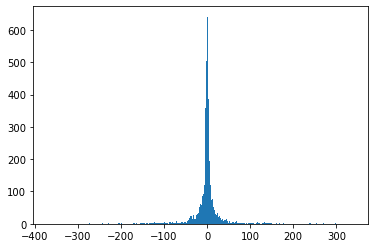

In [131]:
r = d - A.dot(p)
print(r.std())
plt.hist(r, bins="auto")
plt.show()

In [215]:
0.5**2

0.25

In [283]:
def dask_green(e, n, md):
    d = da.sqrt(e**2 + n**2) + md
    return (d**2) * (da.log(d) - 1)

def jacobian_dask(e, n, pe, pn, md):
    A = dask_green(
        e[np.newaxis].T - pe,
        n[np.newaxis].T - pn,
        md
    )
    return A

def scale_dask(x):
    scale_ = da.nanstd(x, axis=0)
    return x/scale_, scale_

def steepest(jacobian, data, damp=0, maxit=100, maxsteps=20, beta=0.1, alpha=0.1, tol=1e-5):
    params = da.zeros(jacobian.shape[1], dtype=data.dtype)
    residuals = data - jacobian.dot(params) 
    misfit = ((residuals**2).sum() + damp*(params**2).sum()).compute()
    # This is a mystic parameter of the Armijo rule
    #alpha = 1e-4
    line_search_start = 0
    for iteration in range(maxit):
        gradient = -jacobian.T.dot(residuals) + damp*params
        gradient = gradient.persist()
        # Calculate now to avoid computing inside the loop
        gradient_norm = (gradient ** 2).sum()
        gradient_norm = gradient_norm.compute()
        # Determine the best step size
        for i in range(line_search_start, maxsteps):
            step_size = beta**i
            update = step_size*gradient
            new_params = params - update
            new_residuals = data - jacobian.dot(new_params)
            new_misfit = (new_residuals**2).sum() + damp*(new_params**2).sum()
            new_misfit = new_misfit.compute()
            if misfit - new_misfit >= alpha*step_size*gradient_norm:
                break
        else:
            print("stagnation", iteration)
            break
        line_search_start = (i*2)//3
        change_rate = abs((new_misfit - misfit) / misfit)
        update_rate = da.max(da.absolute(update)).compute()
        params, residuals = dask.persist(new_params, new_residuals)
        misfit = new_misfit
        print(
            "it:", iteration,
            "line search:", i, 
            "change:", change_rate, 
            "armijo:", alpha*step_size*gradient_norm, 
            "update:", update_rate,
        )
        if change_rate < tol:
            break
    else:
        print("maxit")
    return params

In [306]:
size = 10000
chunk = "100Mb"
X, _ = scale_dask(da.random.uniform(size=(2*size, size), chunks=chunk))
c = da.random.uniform(size=size, chunks=X.chunksize[0])
y = X.dot(c)
X, y = dask.persist(X, y)
print(X.chunks, c.chunks)

((2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500), (2500, 2500, 2500, 2500)) ((2500, 2500, 2500, 2500),)


In [308]:
%%time
c_ = steepest(X, y, damp=0, beta=0.01, maxsteps=100, maxit=50, alpha=1e-4, tol=1e-5)

it: 0 line search: 9 change: 0.8399851708328403 armijo: 90350056.37022583 update: 0.3061195149071814
it: 1 line search: 9 change: 0.8399366337036857 armijo: 14456513.423929574 update: 0.12244919195863825
it: 2 line search: 9 change: 0.8396334323821867 armijo: 2313122.8903397056 update: 0.04897978120926182
it: 3 line search: 9 change: 0.8377435512340037 armijo: 370112.6166485634 update: 0.019591504304036597
it: 4 line search: 9 change: 0.8261229693283946 armijo: 59220.12634633304 update: 0.007835988527630145
it: 5 line search: 9 change: 0.7602218367431504 armijo: 9475.592393014798 update: 0.003133898120580998
it: 6 line search: 9 change: 0.5073210276689928 armijo: 1516.1892674530886 update: 0.0012623151742807606
it: 7 line search: 9 change: 0.1648011756461709 armijo: 242.64033237948624 update: 0.000516019150303863
it: 8 line search: 9 change: 0.03162055537533104 armijo: 38.86539037384435 update: 0.00021877624862314248
it: 9 line search: 9 change: 0.005274549008703049 armijo: 6.260259082

KeyboardInterrupt: 

In [ ]:
np.testing.assert_allclose(c, c_)

distributed.nanny - WARNING - Restarting worker


In [175]:
deast, dnorth, dd = [
    da.from_array(i, chunks=chunk) for i in (east, north, d)
]

In [181]:
%%time
B, scale_ = scale_dask(jacobian_dask(deast, dnorth, deast, dnorth, mindist))
B, dd = dask.persist(B, dd)
#client.rebalance([B, dd])
pa = steepest(B, dd, damp=1e0, beta=0.1)

stagnation 0
CPU times: user 3 s, sys: 170 ms, total: 3.17 s
Wall time: 4.54 s


500.29044


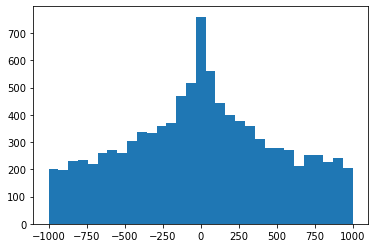

In [179]:
r = d - B.dot(pa).compute()
print(r.std())
plt.hist(r, bins="auto")
plt.show()

In [137]:
np.testing.assert_allclose(B.compute(), A, rtol=1e-3)

In [138]:
np.testing.assert_allclose(B.dot(pa).compute(), A.dot(p), rtol=1e-3)

AssertionError: 
Not equal to tolerance rtol=0.001, atol=0

Mismatch: 100%
Max absolute difference: 1008.60939771
Max relative difference: 920.12044231
 x: array([ 6.594849,  7.068853,  4.835266, ...,  4.81286 , 15.18896 ,
        5.65562 ], dtype=float32)
 y: array([-577.05969 , -268.589054,  167.631707, ...,  -87.984329,
        -62.036079,   10.537311])

In [132]:
%%time
B, scale_ = scale_dask(jacobian_dask(deast, dnorth, deast, dnorth, mindist))
hessian = B.T@B 
gradient = B.T@dd
#gradient = gradient.rechunk(new_chunk)
#hessian = hessian.rechunk(new_chunk)
hessian = hessian + damp*da.eye(size, chunks=chunk, dtype="float32")
dask.persist(hessian, gradient, B)
client.rebalance([hessian, gradient, B])
#pa = da.linalg.solve(hessian, gradient).compute()
H = spsp.interface.MatrixLinearOperator(hessian)
pa, info = spsp.qmr(H, gradient, tol=1e-3)
print(info)
del hessian, gradient, H

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
